#**1) installazione strumenti utilizzati**

#1.1) Installazione di YOLO v8

### Verifica  utilizzo GPU

Selezionare la GPU in Runtime>Cambia tipo di runtime

In [1]:
!nvidia-smi

Thu Sep 28 08:04:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Variabile di gestione dei percorsi

In [2]:
import os
HOME = os.getcwd()
print(HOME)
cartellaVideo = "/content/video"
os.makedirs(cartellaVideo, exist_ok=True) #creo la cartella che conterrà i vari video
cartellaRisultati = "/content/video/result"
os.makedirs(cartellaRisultati, exist_ok=True)
cartellaRisultatiPerCasistiche = "/content/video/result/per_casistiche/"
os.makedirs(cartellaRisultatiPerCasistiche, exist_ok=True)

/content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installazione via pip

In [4]:
!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


#1.2) Installazione di ByteTrack

In [5]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()

import sys
sys.path.append(f"{HOME}/ByteTrack")

import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


#1.3) Installazione Roboflow Supervision

In [6]:
%%capture
%cd {HOME}
!git clone -b svUnibas https://github.com/manuelecapece/VehicleDetecting-VeP-Unibas
%cd {HOME}/VehicleDetecting-VeP-Unibas
!pip install -e '.[dev]'

Import necessari

In [7]:
from ultralytics import YOLO
from IPython.display import display, Image, Video, HTML
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from urllib.request import urlretrieve
from IPython.display import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]

In [8]:
from copy import deepcopy
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from supervision.tools.line_counter_car import LineCounterCar, LineCounterAnnotatorCar
from supervision.tools.line_counter_moto import LineCounterMoto, LineCounterAnnotatorMoto
from supervision.tools.line_counter_bus import LineCounterBus, LineCounterAnnotatorBus
from supervision.tools.line_counter_truck import LineCounterTruck, LineCounterAnnotatorTruck

## Tracking utils

Script costituito dai metodi necessari per il matching delle predizioni fatte da YOLO e la posizione prevista degli oggetti (dato il loro id) con i dati provenienti da ByteTracker

In [9]:
from typing import List

# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))

# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)

# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

#1.4) Load pre trained model

In [10]:
#settings
MODEL = 'yolov8x.pt'

In [11]:
model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 230MB/s]

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


#**2) Sezione di download e setting videos che useremo ai fini dell'object detections**

In [12]:
import shutil
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2.1) Download dei video

Download da drive e salvataggio sul notebook

In [13]:
!pip install gdown
import gdown


In [14]:
#Procedura di download per video >100Mb
# https://drive.google.com/file/d/1AnU3dR5VHUe96xJn2wtE9WSLVSqDetIM/view?usp=sharing LINK VIDEO PZ
file_id = '1AnU3dR5VHUe96xJn2wtE9WSLVSqDetIM'
output_file = '/content/video/day5.mp4'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1AnU3dR5VHUe96xJn2wtE9WSLVSqDetIM
To: /content/video/day5.mp4
100%|██████████| 137M/137M [00:01<00:00, 130MB/s]


'/content/video/day5.mp4'

In [15]:
#Procedura di download per video <100Mb
%cd {HOME}
!wget 'https://drive.google.com/uc?export=download&id=1V25Rr-Kmzk3Jojsm2iKTF_DWouHWVzZO' -O /content/video/day1.mp4    #percorso di day1
!wget 'https://drive.google.com/uc?export=download&id=1V2f4HrvUZTGrDcQmeEXwskyAkjMcTafE' -O /content/video/day2.mp4    #percorso di day2
!wget 'https://drive.google.com/uc?export=download&id=1V3AdL-SxDtgJmgGCMNzDPE8h3m0HppT2' -O /content/video/day3.mp4    #percorso di day3
!wget 'https://drive.google.com/uc?export=download&id=1VC6Ju9ZUoiCBRQNLoGWOrvA3jwg-0cQb' -O /content/video/day4.mp4    #percorso di day4-snow
!wget 'https://drive.google.com/uc?export=download&id=1VBiWlY13H7RVs3h26Rhx5IzuQ8x1BpzA' -O /content/video/night1.mp4  #percorso di night1
!wget 'https://drive.google.com/uc?export=download&id=1VEqMMzO0vsQfRVYa_DkOxZY9MynKrjX_' -O /content/video/night2.mp4  #percorso di night2
!wget 'https://drive.google.com/uc?export=download&id=1VKQmqGP9O8mZ6KlicB9UX3C_pX0wx7LF' -O /content/video/night3.mp4  #percorso di night3-rain

/content
--2023-09-28 08:07:19--  https://drive.google.com/uc?export=download&id=1V25Rr-Kmzk3Jojsm2iKTF_DWouHWVzZO
Resolving drive.google.com (drive.google.com)... 173.194.194.100, 173.194.194.113, 173.194.194.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.194.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s1tckojovgbhl1d2n2fc0dh03q7ss27c/1695888375000/09794783795644671419/*/1V25Rr-Kmzk3Jojsm2iKTF_DWouHWVzZO?e=download&uuid=884e97b8-a994-42e5-9e45-5b09d199492a [following]
--2023-09-28 08:07:21--  https://doc-14-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s1tckojovgbhl1d2n2fc0dh03q7ss27c/1695888375000/09794783795644671419/*/1V25Rr-Kmzk3Jojsm2iKTF_DWouHWVzZO?e=download&uuid=884e97b8-a994-42e5-9e45-5b09d199492a
Resolving doc-14-0k-docs.googleusercontent.com (doc-14-0k-docs.googleusercontent.com)... 209.85.1

In [86]:
PATH_DAY1 = f"{HOME}/video/day1.mp4"
PATH_DAY2 = f"{HOME}/video/day2.mp4"
PATH_DAY3 = f"{HOME}/video/day3.mp4"
PATH_DAY4 = f"{HOME}/video/day4.mp4"
PATH_DAY5 = f"{HOME}/video/day5.mp4"
PATH_NIGHT1 = f"{HOME}/video/night1.mp4"
PATH_NIGHT2 = f"{HOME}/video/night2.mp4"
PATH_NIGHT3 = f"{HOME}/video/night3.mp4"

**Punti** 'linea counting' dei video

In [87]:
punti_day1   = {'SX' : 100, 'SY' : 750, 'EX' : 1920, 'EY' : 750}
punti_day2   = {'SX' : 400, 'SY' : 750, 'EX' : 1650, 'EY' : 750}
punti_day3   = {'SX' : 0  , 'SY' : 770, 'EX' : 1920, 'EY' : 770}
punti_day4   = {'SX' : 150, 'SY' : 800, 'EX' : 1650, 'EY' : 800}
punti_day5   = {'SX' : 270, 'SY' : 600, 'EX' : 1600, 'EY' : 600}
punti_night1 = {'SX' : 125, 'SY' : 800, 'EX' : 1920, 'EY' : 800}
punti_night2 = {'SX' : 250, 'SY' : 650, 'EX' : 1600, 'EY' : 650}
punti_night3 = {'SX' : 280, 'SY' : 800, 'EX' : 1600, 'EY' : 800}

In [88]:
dizionarioVideo = {'video1' : [PATH_DAY1,punti_day1],
                   'video2' : [PATH_DAY2,punti_day2],
                   'video3' : [PATH_DAY3,punti_day3],
                   'video4' : [PATH_DAY4,punti_day4],
                   'video5' : [PATH_DAY5,punti_day5],
                   'video6' : [PATH_NIGHT1,punti_night1],
                   'video7' : [PATH_NIGHT2,punti_night2],
                   'video8' : [PATH_NIGHT3,punti_night3],}

#2.2) Cambia qui il percorso del video

In [89]:
video = dizionarioVideo['video5'] #cambia qui il video
SOURCE_VIDEO_PATH = video[0]
CORD_LINES = video[1]

#**3)** **Track and Count Objects Using YOLOv8**

#3.1) Predict and annotate single frame

### Costruzione di una pipeline di inferenza personalizzata con Supervision per un singolo frame

In [90]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7] #2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'

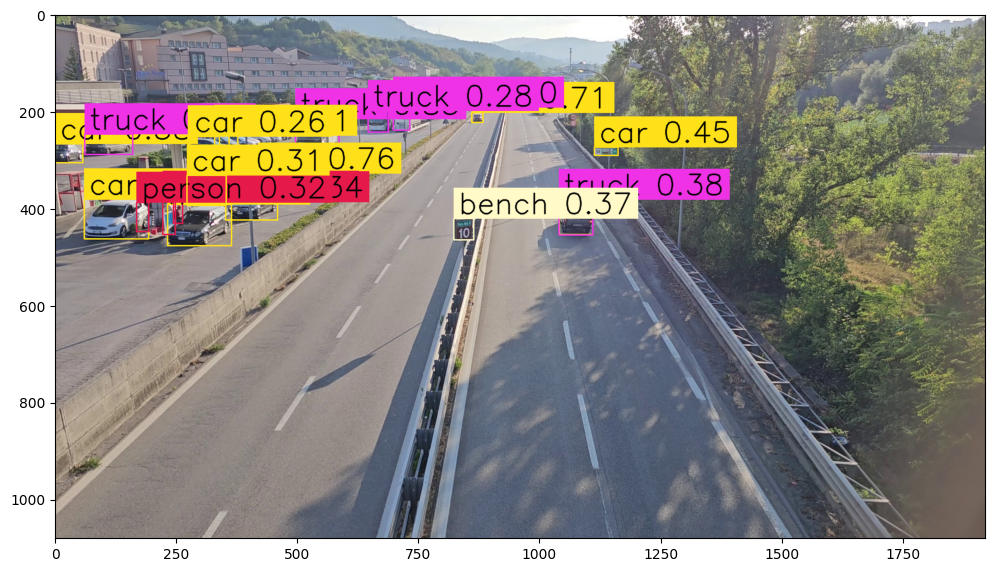

In [91]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)     #print(type(frame)) --> <class numpy.ndarray>
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (12, 12))

Verifica dei punti per disegnare la linea

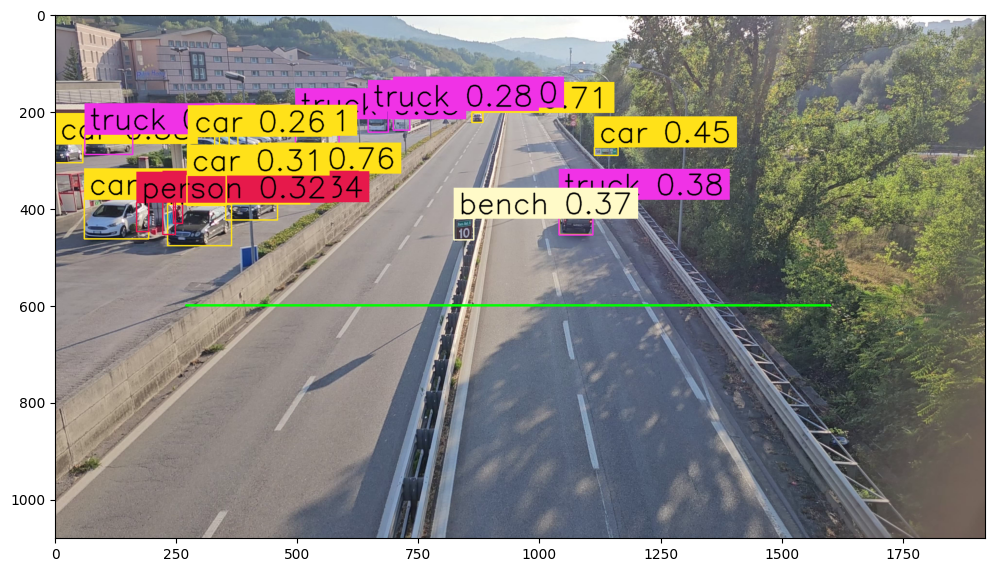

In [93]:
temp_image_path = 'temp_image.png'
cv2.imwrite(temp_image_path, frame)
image = cv2.imread(temp_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
start_point = (CORD_LINES['SX'], CORD_LINES['SY'])
end_point = (CORD_LINES['EX'],CORD_LINES['EY'])
color = (0, 255, 0)
thickness = 4
cv2.line(image_rgb, start_point, end_point, color, thickness)
plt.imshow(image_rgb)

#3.2) Predict and annotate whole video

### 3.2.1) Costruzione di una pipeline di inferenza personalizzata per un video intero, tracciamento dei detections e conteggio dei veicoli che attraversano la linea con Supervision

In [94]:
def getTargetVideoPath(sourceVideoPath):
  targetVideoPath = sourceVideoPath[:14] + '/result' + sourceVideoPath[14:]
  targetVideoPath = targetVideoPath.replace('.mp4','-predict.mp4')
  return targetVideoPath
  end

In [95]:
# settings
LINE_START = Point(CORD_LINES['SX'], CORD_LINES['SY'])
LINE_END = Point(CORD_LINES['EX'],CORD_LINES['EY'])
TARGET_VIDEO_PATH = getTargetVideoPath(SOURCE_VIDEO_PATH)

In [96]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=1592)

In [97]:
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=1)
line_annotator = LineCounterAnnotator(thickness=1, text_thickness=2, text_scale=1)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/1592 [00:00<?, ?it/s]

Salvataggio video nella cartella drive specificando il percorso del proprio drive

In [98]:
#Con questo percorso il video viene salvato nel drive condiviso 'Progetto V&P' e può essere visualizzato nella cartella video
destination_folder = '/content/drive/Shareddrives/Progetto V&P/Video/predict/generale/'
shutil.copy(TARGET_VIDEO_PATH, destination_folder)

'/content/drive/Shareddrives/Progetto V&P/Video/predict/generale/day5-predict.mp4'

[Cartella drive con il video realizzato](https://drive.google.com/drive/u/0/folders/16LPi6KCjo5Ec_zKg3ncgdhVD7qMk99HK)

### 3.2.2) Costruzione di una pipeline di inferenza personalizzata per un video intero, tracciamento dei detections e conteggio degli oggetti che attraversano la linea con Supervision, **suddivisi in base alla classe_id alla quale appartengono**

In [99]:
def getTargetVideoPath(sourceVideoPath):
  targetVideoPath = sourceVideoPath[:14] + '/result/per_casistiche' + sourceVideoPath[14:]
  targetVideoPath = targetVideoPath.replace('.mp4','-predict.mp4')
  return targetVideoPath
  end

In [100]:
# settings
LINE_START = Point(CORD_LINES['SX'], CORD_LINES['SY'])
LINE_END = Point(CORD_LINES['EX'],CORD_LINES['EY'])
TARGET_VIDEO_CATEGORY_PATH = getTargetVideoPath(SOURCE_VIDEO_PATH)

In [101]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=1592)

In [102]:
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instances
line_counter_car = LineCounterCar(start=LINE_START, end=LINE_END)
line_counter_moto = LineCounterMoto(start=LINE_START, end=LINE_END)
line_counter_bus = LineCounterBus(start=LINE_START, end=LINE_END)
line_counter_truck = LineCounterTruck(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and instances of LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=1)
line_annotator_car = LineCounterAnnotatorCar(thickness=2, text_thickness=2, text_scale=1)
line_annotator_moto = LineCounterAnnotatorMoto(thickness=2, text_thickness=2, text_scale=1)
line_annotator_bus = LineCounterAnnotatorBus(thickness=2, text_thickness=2, text_scale=1)
line_annotator_truck = LineCounterAnnotatorTruck(thickness=2, text_thickness=2, text_scale=1)

# open target video file
with VideoSink(TARGET_VIDEO_CATEGORY_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]

        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

        # filtering updating line counter car and filtering out detections with class_id = 3, 5, 7
        detections_car =  deepcopy(detections)
        mask_car = deepcopy(mask)
        mask_car = np.array([class_id in [2] for class_id in detections_car.class_id], dtype=bool)
        detections_car.filter(mask=mask_car, inplace=True)
        line_counter_car.update(detections=detections_car)

        # filtering updating line counter moto and filtering out detections with class_id = 2, 5, 7
        detections_moto =  deepcopy(detections)  #detections
        mask_moto = deepcopy(mask)
        mask_moto = np.array([class_id in [3] for class_id in detections_moto.class_id], dtype=bool)
        detections_moto.filter(mask=mask_moto, inplace=True)
        line_counter_moto.update(detections=detections_moto)

        # filtering updating line counter bus and filtering out detections with class_id = 2, 3, 7
        detections_bus =  deepcopy(detections)  #detections
        mask_bus = deepcopy(mask)
        mask_bus = np.array([class_id in [5] for class_id in detections_bus.class_id], dtype=bool)
        detections_bus.filter(mask=mask_bus, inplace=True)
        line_counter_bus.update(detections=detections_bus)

        # filtering updating line counter truck and filtering out detections with class_id = 2, 3, 5
        detections_truck = deepcopy(detections)
        mask_truck = deepcopy(mask)
        mask_truck = np.array([class_id in [7] for class_id in detections_truck.class_id], dtype=bool)
        detections_truck.filter(mask=mask_truck, inplace = True)
        line_counter_truck.update(detections=detections_truck)

        # annotate and display frame
        line_annotator_car.annotateCar(frame=frame, line_counter_car=line_counter_car)
        line_annotator_moto.annotateMoto(frame=frame, line_counter_moto=line_counter_moto)
        line_annotator_bus.annotateBus(frame=frame, line_counter_bus=line_counter_bus)
        line_annotator_truck.annotateTruck(frame=frame, line_counter_truck=line_counter_truck)
        sink.write_frame(frame)

  0%|          | 0/1592 [00:00<?, ?it/s]

Salvataggio video nella cartella drive

In [103]:
#Con questo percorso il video viene salvato nel drive condiviso 'Progetto V&P' e può essere visualizzato nella cartella video
destination_folder = '/content/drive/Shareddrives/Progetto V&P/Video/predict/categorie/'
shutil.copy(TARGET_VIDEO_CATEGORY_PATH, destination_folder)

'/content/drive/Shareddrives/Progetto V&P/Video/predict/categorie/day5-predict.mp4'

[Cartella drive con il video realizzato](https://drive.google.com/drive/u/0/folders/166-pnjjHR7Hbce5EWeJq9bJYAmHB9coH)